In [ ]:
!pip install modal-client
!pip install hopsworks
!pip install dataframe_image
!pip install gradio
!pip install Faker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 173 kB 8.5 MB/s 
     |████████████████████████████████| 62 kB 576 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 168 kB 40.9 MB/s 
     |████████████████████████████████| 1.2 MB 40.1 MB/s 
     |████████████████████████████████| 237 kB 50.0 MB/s 
     |████████████████████████████████| 55 kB 4.3 MB/s 
     |████████████████████████████████| 57 kB 6.1 MB/s 
     |████████████████████████████████| 51 kB 7.3 MB/s 
     |████████████████████████████████| 64 kB 2.7 MB/s 
     |████████████████████████████████| 80 kB 10.5 MB/s 
     |████████████████████████████████| 140 kB 63.7 MB/s 
  Created wheel for grpclib: filename=grpclib-0.4.3-py3-none-any.whl size=77081 sha256=03b7279a9ac356a165498ebd470878ec2efa63df716fe8cfba6e3c12a21191

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.6 MB 8.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.6 MB 7.6 MB/s 
     |████████████████████████████████| 278 kB 66.1 MB/s 
     |████████████████████████████████| 84 kB 3.5 MB/s 
     |████████████████████████████████| 84 kB 4.6 MB/s 
     |████████████████████████████████| 106 kB 68.0 MB/s 
     |████████████████████████████████| 2.3 MB 55.2 MB/s 
     |████████████████████████████████| 56 kB 5.5 MB/s 
     |████████████████████████████████| 213 kB 52.0 MB/s 
     |████████████████████████████████| 54 kB 3.5 MB/s 
     |████████████████████████████████| 68 kB 7.4 MB/s 
     |████████████████████████████████| 68 kB 7.6 MB/s 
     |████████████████████████████████| 68 kB 7.4 MB/s 
     |████████████████████████████████| 46 kB 4.4 MB/s 
     |█

In [ ]:

def read_and_clean_titanic():
  import pandas as pd
  #The cleaning is from https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial
  df = pd.read_csv("https://raw.githubusercontent.com/ID2223KTH/id2223kth.github.io/master/assignments/lab1/titanic.csv")

  df_corr = df.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
  df_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
  df_corr[df_corr['Feature 1'] == 'Age']


  age_by_pclass_sex = df.groupby(['Sex', 'Pclass']).median()['Age']
  # Filling the missing values in Age with the medians of Sex and Pclass groups
  df['Age'] = df.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

  df[df['Embarked'].isnull()]
  df['Embarked'] = df['Embarked'].fillna('S')

  med_fare = df.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
  # Filling the missing value in Fare with the median Fare of 3rd class alone passenger
  df['Fare'] = df['Fare'].fillna(med_fare)


  df['Deck'] = df['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

  df_all_decks = df.groupby(['Deck', 'Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 
                                                                          'Fare', 'Embarked', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name': 'Count'}).transpose()

  idx = df[df['Deck'] == 'T'].index
  df.loc[idx, 'Deck'] = 'A'

  df['Deck'] = df['Deck'].replace(['A', 'B', 'C'], 'ABC')
  df['Deck'] = df['Deck'].replace(['D', 'E'], 'DE')
  df['Deck'] = df['Deck'].replace(['F', 'G'], 'FG')

  df.drop(['Cabin'], inplace=True, axis=1)

  #df['Fare'] = pd.qcut(df['Fare'], 13)
  #df['Age'] = pd.qcut(df['Age'], 10)
  df['Family_Size'] = df['SibSp'] + df['Parch'] + 1
  family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
  df['Family_Size_Grouped'] = df['Family_Size'].map(family_map)
  df['Ticket_Frequency'] = df.groupby('Ticket')['Ticket'].transform('count')
  df['Title'] = df['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
  df['Is_Married'] = 0
  df['Is_Married'].loc[df['Title'] == 'Mrs'] = 1
  df['Title'] = df['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
  df['Title'] = df['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')

  df['Family'] = extract_surname(df['Name'])
  df.drop(columns='PassengerId', inplace=True)
  return df

def extract_surname(data):    
    import string

    families = []
    
    for i in range(len(data)):        
        name = data.iloc[i]

        if '(' in name:
            name_no_bracket = name.split('(')[0] 
        else:
            name_no_bracket = name
            
        family = name_no_bracket.split(',')[0]
        title = name_no_bracket.split(',')[1].strip().split(' ')[0]
        
        for c in string.punctuation:
            family = family.replace(c, '').strip()
            
        families.append(family)
            
    return families

def encode_features(df):
  from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
  import pandas as pd
  non_numeric_features = ['embarked', 'sex', 'deck', 'title', 'family_size_grouped']
  for feature in non_numeric_features:
    df[feature] = LabelEncoder().fit_transform(df[feature])

  
  cat_features = ['pclass', 'sex', 'deck', 'embarked', 'title', 'family_size_grouped']
  encoded_features = []
  for feature in cat_features:
    encoded_feat = OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
    n = df[feature].nunique()
    cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
    encoded_df = pd.DataFrame(encoded_feat, columns=cols)
    encoded_df.index = df.index
    encoded_features.append(encoded_df)
  df = pd.concat([df, *encoded_features], axis=1)
  drop_cols = ['deck', 'embarked', 'family', 'family_size', 'family_size_grouped',
             'name', 'parch', 'pclass', 'sex', 'sibsp', 'ticket', 'title']

  df.drop(columns=drop_cols, inplace=True)
  return df #Return a df with encoded labels

In [ ]:
#Training Feature pipeline
#Denna cell laddar upp titanic dataset och skickar till hopsworks
import os
#import modal


LOCAL = True

if LOCAL == False:
    stub = modal.Stub()
    image = modal.Image.debian_slim().pip_install(["hopsworks","joblib","seaborn","sklearn","dataframe-image"]) 

    @stub.function(image=image, schedule=modal.Period(days=1), secret=modal.Secret.from_name("id2223v2"))
    def f():
        g()
def g():
  import hopsworks
  import pandas as pd
  feature_list = []
  
  project = hopsworks.login()
  fs = project.get_feature_store()
  titanic_df = read_and_clean_titanic()

  for features in titanic_df.columns:
    if features != "Survived":
      feature_list.append(features)
    else:
      continue
  titanic_fg = fs.get_or_create_feature_group(
      name="titanic_modal_2",
      version=1,
      primary_key= feature_list,
      description = "Titanic survival-rate dataset")
  titanic_fg.insert(titanic_df, write_options={"wait_for_job" : False})
  
  
if __name__ == "__main__":
  if LOCAL == True :
      g()
  else:
      with stub.run():
          f()




Copy your Api Key (first register/login): https://c.app.hopsworks.ai/account/api/generated

Paste it here: ··········
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/4251


Connected. Call `.close()` to terminate connection gracefully.


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Uploading Dataframe: 0.00% |          | Rows 0/891 | Elapsed Time: 00:00 | Remaining Time: ?

Launching offline feature group backfill job...
Backfill Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/4251/jobs/named/titanic_modal_2_1_offline_fg_backfill/executions


Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/4251
Connected. Call `.close()` to terminate connection gracefully.


Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/4251/models/titanic_modal_RF/1


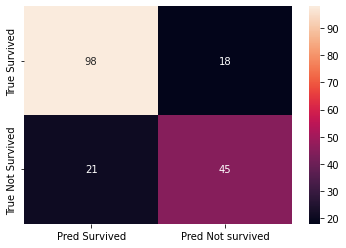

In [ ]:
#Model pipeline
#Hämtar titanic dataset från hopsworks, tränar xgboost model och skickar modellen till hopsworks
LOCAL=True
import os


if LOCAL == False:
   stub = modal.Stub()
   image = modal.Image.debian_slim().apt_install(["libgomp1"]).pip_install(["hopsworks", "seaborn", "joblib", "scikit-learn"])

   @stub.function(image=image, schedule=modal.Period(days=1), secret=modal.Secret.from_name("id2223v2")) ##Inser name of MODAL api key
   def f():
       g()

def g():
    import hopsworks
    import pandas as pd
    #import xgboost as xgb
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    import seaborn as sns
    from matplotlib import pyplot
    from hsml.schema import Schema
    from hsml.model_schema import ModelSchema
    import joblib

    project = hopsworks.login()
    fs = project.get_feature_store()
    try: 
      feature_view = fs.get_feature_view(name="titanic_modal_2", version=1)
    except:
      titanic_fg = fs.get_feature_group(name="titanic_modal_2", version=1)
      query = titanic_fg.select_all()
      feature_view = fs.create_feature_view(name="titanic_modal_2",
                                        version=1,
                                        description="Read from Titanic survival-rate dataset",
                                        labels=["Survived"],
                                        query=query)
    
    X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)
    

    #Encodas X_train och X_Test
    X_train = encode_features(X_train)
    X_test = encode_features(X_test)

    #model = xgb.XGBClassifier()
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    metrics = classification_report(y_test, y_pred, output_dict=True)
    results = confusion_matrix(y_test, y_pred)

    # Create the confusion matrix as a figure, we will later store it as a PNG image file
    df_cm = pd.DataFrame(results, ['True Survived', 'True Not Survived'],
                          ['Pred Survived', 'Pred Not survived'])
    cm = sns.heatmap(df_cm, annot=True)
    fig = cm.get_figure()

    mr = project.get_model_registry()

    model_dir = "titanic_model_RF"
    if os.path.isdir(model_dir) == False:
      os.mkdir(model_dir)
    
    joblib.dump(model, model_dir + "/titanic_model_RF.pkl")
    fig.savefig(model_dir + "/confusion_matrix.png")

    input_schema = Schema(X_train)
    output_schema = Schema(y_train)
    model_schema = ModelSchema(input_schema, output_schema)

    titanic_model = mr.python.create_model(
        name="titanic_modal_RF",
        metrics={"accuracy" : metrics['accuracy']},
        model_schema=model_schema,
        description="Titanic survival predictor"
    )

    titanic_model.save(model_dir)

if __name__ == "__main__":
    if LOCAL == True :
        g()
    else:
        with stub.run():
            f()


In [ ]:
#Funktion för att generate samples som vi kan predicta på
def fake_sample():
  import pandas as pd
  import random
  from faker import Faker
  faker = Faker()
  age = random.randint(5, 90)
  deck_list = ["ABC", "DE", "FG", "M"]
  deck = random.choice(deck_list)
  
  pclass = 0
  if deck == "ABC":
    pclass = 1
  elif deck == "DE":
    pclass = random.choice([2,3])
  elif deck == "FG":
    pclass = random.choice([2,3])
  else:
    pclass = 3
  
  sex = random.choice(["male", "female"])
  title = None
  if sex == "male":
    name = faker.name_male()
    title = "Mr"
  else:
    name = faker.name_female()
    title = "Miss/Mrs/Ms"


  df = pd.DataFrame({ 
         "age" : [float(age)],
         "deck" : [deck],
         "embarked" : [random.choice(["S", "C", "Q"])],
         "family" : [name.split()[1]],
         "family_size" : [1],
         "family_size_grouped" : ["Alone"],
         "fare" : [random.uniform(10, 100)],
         "is_married" : 0,
         "name" : [name.split()[1] + ", " + name.split()[0]],
         "parch" : [0],
         "pclass" : [pclass],
         "sex" : [sex],
         "sibsp" : [0],
         "ticket" : [str(random.randint(2500, 25000))],
         "ticket_frequency" : [1],
         "title" : [title] 
         })
  df['survived'] = random.randint(0, 1)
  return df




      


In [ ]:
#Genarate and input a random sample for the dataset
#Skapar nya samples till vårt dataset i hopsworks

import os
#import modal
    
BACKFILL=False
LOCAL=True

if LOCAL == False:
   stub = modal.Stub()
   image = modal.Image.debian_slim().pip_install(["hopsworks","joblib","seaborn","sklearn","dataframe-image"]) 

   @stub.function(image=image, schedule=modal.Period(days=1), secret=modal.Secret.from_name("id2223v2"))
   def f():
       g()

def g():
  import hopsworks
  import pandas as pd
  
  project = hopsworks.login()
  fs = project.get_feature_store()

  if BACKFILL == True:
    titanic_df = read_and_clean_titanic()
  else:
    titanic_df = fake_sample()
    print(titanic_df)
  feature_list = []
  for features in titanic_df.columns:
    if features != "Survived":
      feature_list.append(features)
    else:
      continue
  titanic_fg = fs.get_or_create_feature_group(
      name = "titanic_modal_2",
      version=1,
      primary_key = feature_list,
      description  = "Titanic Survival Dataset")

  titanic_fg.insert(titanic_df, write_options={"wait_for_job" : False})

if __name__ == "__main__":
  if LOCAL == True:
    g()
  else:
    with stub.run():
      f()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/4251
Connected. Call `.close()` to terminate connection gracefully.
    age deck embarked    family  family_size family_size_grouped       fare  \
0  80.0   DE        S  Campbell            1               Alone  75.865177   

   is_married               name  parch  pclass     sex  sibsp ticket  \
0           0  Campbell, Brianna      0       2  female      0  23261   

   ticket_frequency        title  survived  
0                 1  Miss/Mrs/Ms         1  


Uploading Dataframe: 0.00% |          | Rows 0/1 | Elapsed Time: 00:00 | Remaining Time: ?

Launching offline feature group backfill job...
Backfill Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/4251/jobs/named/titanic_modal_2_1_offline_fg_backfill/executions


Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/4251
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.

Predicted: Survived
Truth: Survived


Uploading Dataframe: 0.00% |          | Rows 0/1 | Elapsed Time: 00:00 | Remaining Time: ?

Launching offline feature group backfill job...
Backfill Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/4251/jobs/named/titanic_predictions_1_offline_fg_backfill/executions


Uploading: 0.000%|          | 0/23189 elapsed<00:00 remaining<?

Predictions:      prediction
0            0
1            0
2            0
3            0
4            1
5            1
6            1
7            0
8            0
9            1
10           0
11           0
12           0
13           0
14           1
15           1
16           1
0            1
Labels:      label
0       1
1       1
2       1
3       0
4       1
5       1
6       1
7       1
8       1
9       1
10      1
11      1
12      1
13      1
14      1
15      1
16      1
0       1
Number of different titanic predictions to date: 2


Uploading: 0.000%|          | 0/10124 elapsed<00:00 remaining<?

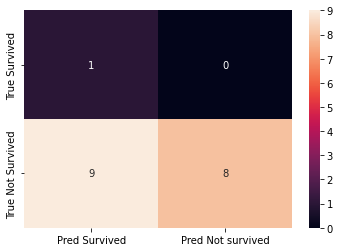

In [ ]:
#batch-inference-pipeline.
#plockar data från hopsworks och predictar på det senast inlagda samplen. Skickar sedan upp en confusion matrix

import os
#import modal
    
LOCAL=True

if LOCAL == False:
   stub = modal.Stub()
   hopsworks_image = modal.Image.debian_slim().pip_install(["hopsworks","joblib","seaborn","sklearn","dataframe-image"])
   @stub.function(image=hopsworks_image, schedule=modal.Period(days=1), secret=modal.Secret.from_name("id2223v2"))
   def f():
       g()

def g():
    import pandas as pd
    import hopsworks
    import joblib
    import datetime
    from PIL import Image
    from datetime import datetime
    import dataframe_image as dfi
    from sklearn.metrics import confusion_matrix
    from matplotlib import pyplot
    import seaborn as sns
    import requests

    project = hopsworks.login()
    fs = project.get_feature_store()

    mr = project.get_model_registry()
    model = mr.get_model("titanic_modal_RF", version=1)
    model_dir = model.download()
    model = joblib.load(model_dir + "/titanic_model_RF.pkl")

    feature_view = fs.get_feature_view(name="titanic_modal_2", version=1)
    batch_data = feature_view.get_batch_data()
    #Encode the data
    batch_data = encode_features(batch_data)
    y_pred = model.predict(batch_data)
    prediction = y_pred[y_pred.size-1] #Latest prediction
    
    if prediction == 0:
      print("Predicted: Not Survived")
    else:
      print("Predicted: Survived")

    titanic_fg = fs.get_feature_group(name="titanic_modal_2", version=1)
    df = titanic_fg.read()
    # print(df["variety"])
    label = df.iloc[-1]["survived"]

    if label == 0:
      print("Truth: Not Survived")
    else:
      print("Truth: Survived")
    dataset_api = project.get_dataset_api() 

    monitor_fg = fs.get_or_create_feature_group(
        name= "titanic_predictions",
        version=1,
        primary_key = ["datetime"],
        description = "Titanic surivival predictor"
    )

    now = datetime.now().strftime("%m/%d/%Y, %H:%M:%S")
    data = {
        'prediction' : [prediction],
        'label' : [label],
        'datetime' : [now]
    }

    monitor_df = pd.DataFrame(data)
    monitor_fg.insert(monitor_df, write_options={"wait_for_job" : False})

    history_df = monitor_fg.read()
    history_df = pd.concat([history_df, monitor_df])

    df_recent = history_df.tail(5)
    dfi.export(df_recent, './df_recent.png', table_conversion = 'matplotlib')
    dataset_api.upload("./df_recent.png", "Resources/images", overwrite=True)




    predictions = history_df[['prediction']]
    labels = history_df[['label']]

    print("Predictions: ", predictions)
    print("Labels: ", labels)

    # Only create the confusion matrix when our titanic_predictions feature group has examples of all 3 iris flowers
    print("Number of different titanic predictions to date: " + str(predictions.value_counts().count()))
    if predictions.value_counts().count() == 2:
        results = confusion_matrix(labels, predictions)
    
        df_cm = pd.DataFrame(results, ['True Survived', 'True Not Survived'],
                          ['Pred Survived', 'Pred Not survived'])
    
        cm = sns.heatmap(df_cm, annot=True)
        fig = cm.get_figure()
        fig.savefig("./confusion_matrix.png")
        dataset_api.upload("./confusion_matrix.png", "Resources/images", overwrite=True)
    else:
        print("You need 3 different predictions to create the confusion matrix.")
        print("Run the batch inference pipeline more times until you get 3 different predictions") 


if __name__ == "__main__":
    if LOCAL == True :
        g()
    else:
        with stub.run():
            f()

In [ ]:
import gradio as gr
import numpy as np
#from PIL import Image
#import requests
import random
import hopsworks
import joblib
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler


project = hopsworks.login()
fs = project.get_feature_store()


mr = project.get_model_registry()
model = mr.get_model("titanic_modal_RF", version=1)
model_dir = model.download()
model = joblib.load(model_dir + "/titanic_model_RF.pkl")

def encode_features(df):
  non_numeric_features = ['embarked', 'sex', 'deck', 'title', 'family_size_grouped']
  for feature in non_numeric_features:
    df[feature] = LabelEncoder().fit_transform(df[feature])

  
  cat_features = ['pclass', 'sex', 'deck', 'embarked', 'title', 'family_size_grouped']
  encoded_features = []
  for feature in cat_features:
    encoded_feat = OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
    n = df[feature].nunique()
    cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
    encoded_df = pd.DataFrame(encoded_feat, columns=cols)
    encoded_df.index = df.index
    encoded_features.append(encoded_df)
  df = pd.concat([df, *encoded_features], axis=1)
  drop_cols = ['deck', 'embarked', 'family', 'family_size', 'family_size_grouped',
             'name', 'parch', 'pclass', 'sex', 'sibsp', 'ticket', 'title']

  df.drop(columns=drop_cols, inplace=True)
  return df #Return a df with encoded labels


def titanic(age, deck, embarked, name, family_size, family_size_grouped, fare, is_married, parch, sibsp, sex, ticket_number, title):

    pclass = 0
    if deck == "ABC":
        pclass = 1

    elif deck == "DE":
        pclass = random.choice([2,3])
        
    elif deck == "FG":
        pclass = random.choice([2,3])
    else:
        pclass = 3
    
    df = pd.DataFrame({ 
         "age" : [age],
         "deck" : [deck],
         "embarked" : [embarked],
         "family" : [name.split()[1]],
         "family_size" : [family_size],
         "family_size_grouped" : [family_size_grouped],
         "fare" : [fare],
         "is_married" : [is_married],
         "name" : [name.split()[1] + ", " + name.split()[0]],
         "parch" : [parch],
         "pclass" : [pclass],
         "sex" : [sex],
         "sibsp" : [sibsp],
         "ticket" : [str(ticket_number)],
         "ticket_frequency" : [1],
         "title" : [title] 
         })
    return df

def predictor(age, deck, embarked, name, family_size, family_size_grouped, fare, is_married, parch, sibsp, sex, ticket_number, title):
    feature_view = fs.get_feature_view(name="titanic_modal_2", version=1)
    batch_data = feature_view.get_batch_data()
    row = titanic(age, deck, embarked, name, family_size, family_size_grouped, fare, is_married, parch, sibsp, sex, ticket_number, title)
    batch_data = batch_data.append(row)
    encoded = encode_features(batch_data)
    y_pred = model.predict(encoded)
    prediction = y_pred[y_pred.size-1]
    if prediction == 0:
        survived = "This person survived"
    if prediction == 1:
        survived = "This person did not survive"
    return survived

demo = gr.Interface(
    fn=predictor,
    title="Titanic Survivor Predictive Analytics",
    description="Titanic survivor experiment.",
    allow_flagging="never",
    inputs=[
        gr.inputs.Number(label="age (10-99)"),
        gr.inputs.Textbox(label="Deck (ABC, DE, FG, or M)"),
        gr.inputs.Textbox(label="Embarked (S, C, or Q)"),
        gr.inputs.Textbox(label="Name of person"),
        #gr.inputs.Textbox(label="Family name"),
        gr.inputs.Number(label="Size of family  (integer)"),
        gr.inputs.Textbox(label="Family Size (Alone, Small, Medium or Large)"),
        gr.inputs.Number(label="Fare (Integer)"),
        gr.inputs.Number(label="Is the person married (0 for no, 1 for yes)"),
        gr.inputs.Number(label="Number of Parent/Children onboard (Integer)"),
        gr.inputs.Number(label="Number of siblings onboard (Integer)"),
        gr.inputs.Textbox(label="Sex"),
        gr.inputs.Number(label="Ticket number"),
        gr.inputs.Textbox(label="Title (Mr, Miss, etc)"),
        ],
    outputs="text")

demo.launch()



Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/4251
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>